In [10]:
from pickle import load
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from chainconsumer import ChainConsumer

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from anstey.generate import T_CMB
from src.spherical_harmonics import RealSphericalHarmonics, calc_spherical_harmonic_matrix
from src.nregions_models import pix_forward_model_pl, genopt_pix_forward_model_pl
from src.blockmat import BlockMatrix, BlockVector
RS = RealSphericalHarmonics()
from nregions_inference import nuarr
import nregions_inference as NRI
from scipy.optimize import curve_fit
from functools import partial
import alm_polynomial_inference as api
from src.inference import curve_fit_emcee
import src.observing as OBS
import src.map_making as MM
import src.spherical_harmonics as SH

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler

alm2temp = 1/np.sqrt(4*np.pi)

In [14]:
lmax=32
nside=32
Nlmax=RS.get_size(lmax)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=True)
mat_Y = calc_spherical_harmonic_matrix(nside, lmax)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


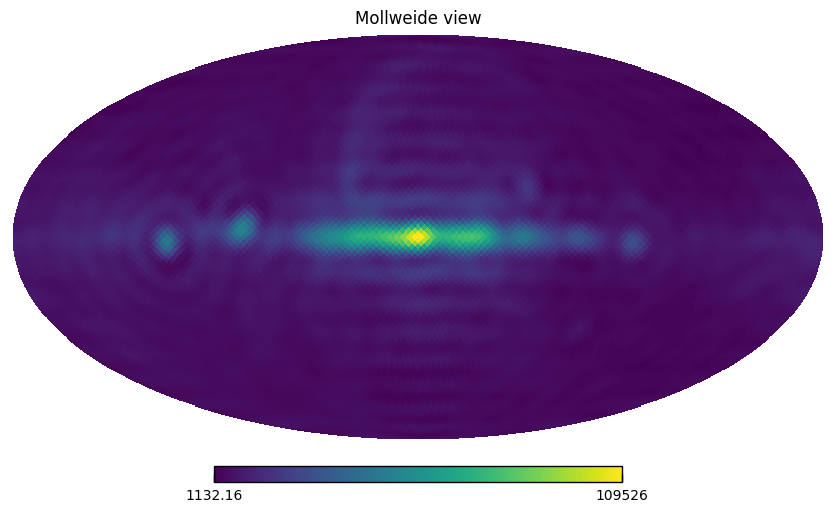

In [3]:
hp.mollview(mat_Y@fg_alm[Nlmax:2*Nlmax])

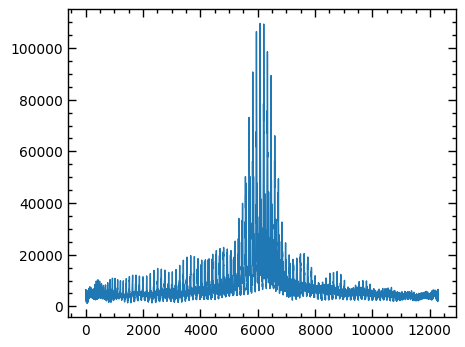

In [4]:
plt.plot(mat_Y@fg_alm[Nlmax:2*Nlmax])

In [15]:
# Load all relevant chromaticity correction data.
corr = np.load('saves/Binwise/chrom_corr.npy')
timestream = np.load('saves/Binwise/dnoisy_vector.npy')
timestream_corr = np.load('saves/Binwise/dnoisy_vector_corr.npy')
timestream_noise = np.load('saves/Binwise/noise.npy')
binned = np.load('saves/Binwise/Nant<7>_Npoly<3>_chrom<1.6e-02>_HS_data.npy')
binnederr = np.load('saves/Binwise/Nant<7>_Npoly<3>_chrom<1.6e-02>_HS_dataerr.npy')
mat_PYB = np.load('saves/Binwise/mat_PYB.npy')
mat_G = np.load('saves/Binwise/mat_G.npy')
alldata = [corr, timestream, timestream_corr, timestream_noise, binned]
for d in alldata:
    print(d.shape)

Nt = int(corr.shape[0]/binned.shape[0])

(4284,)
(4284,)
(4284,)
(4284,)
(51,)


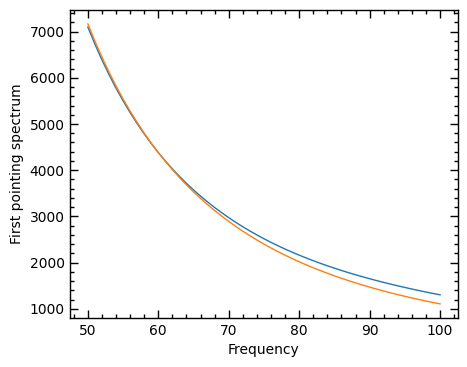

In [6]:
plt.plot(nuarr,timestream[::Nt], label='uncorrected')
plt.plot(nuarr,timestream_corr[::Nt], label='corrected')
plt.ylabel('First pointing spectrum')
plt.xlabel('Frequency')
plt.show()

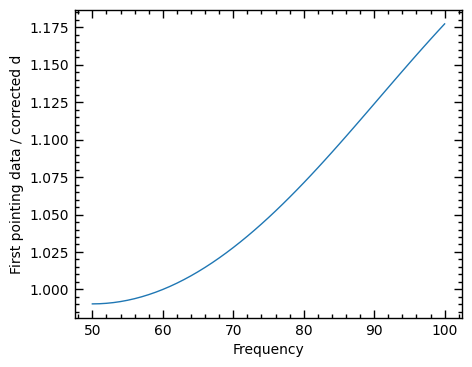

In [7]:
plt.plot(nuarr,timestream[::Nt]/timestream_corr[::Nt])
plt.ylabel('First pointing data / corrected d')
plt.xlabel('Frequency')
plt.show()

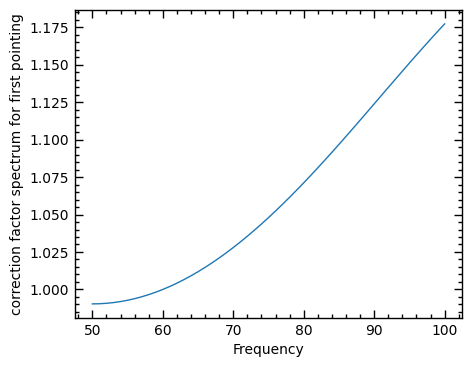

In [8]:
plt.plot(nuarr,corr[::Nt])
plt.ylabel('correction factor spectrum for first pointing')
plt.xlabel('Frequency')
plt.show()

In [9]:
corr_sep = [corr[i::Nt] for i in range(Nt)]

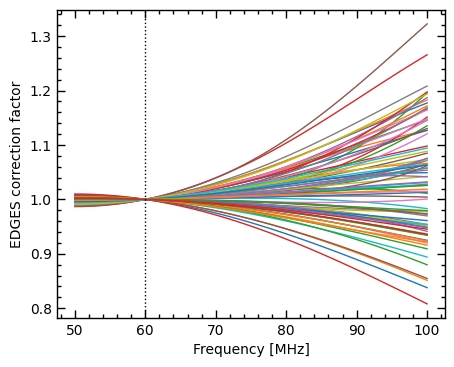

Text(0, 0.5, 'EDGES correction factor')

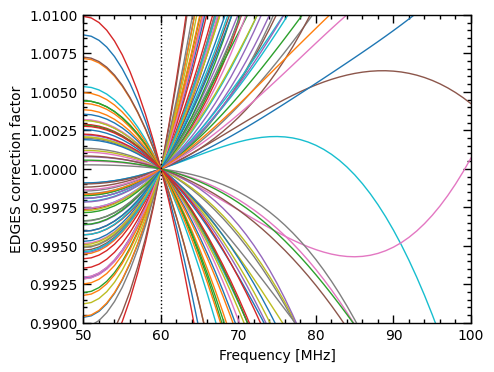

In [19]:
for cfac in corr_sep:
    plt.plot(nuarr, cfac)
plt.axvline(60, linestyle=':', color='k')
plt.xlabel("Frequency [MHz]")
plt.ylabel("EDGES correction factor")
plt.show()
for cfac in corr_sep:
    plt.plot(nuarr, cfac)
plt.ylim(0.99,1.01)
plt.xlim(50,100)
plt.axvline(60, linestyle=':', color='k')
plt.xlabel("Frequency [MHz]")
plt.ylabel("EDGES correction factor")

Initial guess from curve_fit: [ 4.37928019 -2.57575799  0.39617603]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 267.49it/s]


Initial guess from curve_fit: [ 4.37935177e+00 -2.69999343e+00 -1.67104205e-05]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.88it/s]


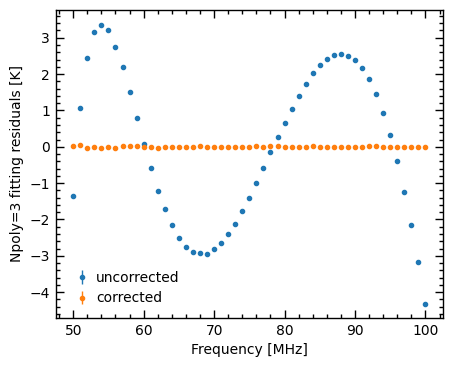

In [11]:
# Fit a polynomial to corrected and uncorrected timeseries data from 
# pointing 1, to see if the chromaticity correction helps at all.
ts_1 = timestream[::Nt]
ts_corr_1 = timestream_corr[::Nt]
sigma_1 = timestream_noise[::Nt]

# First remove the 21-cm global signal from the first pointing.
cm21_temp = SM.cm21_globalT(nuarr, *OBS.cm21_params)
# for the uncorrected data...

ts_fg_1 = ts_1 - cm21_temp
# and for the corrected data...
ts_corr_fg_1 = ts_corr_1 - cm21_temp/corr[0]  # Note: have to normalise the 21-cm signal by the correction.

# Fit polynomials to this.
def fg_polymod(nuarr, *theta_fg):
    Afg, alpha = theta_fg[:2]
    zetas      = theta_fg[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    fg_a00_terms = (Afg*1e3)*(nuarr/60)**alpha * np.exp(np.sum(exponent, 0))
    return fg_a00_terms + T_CMB

Npoly=3
p0 = [10, -2.5]
p0 += [0.01]*(Npoly-2)
priors = [[1, 25], [-3.5, -1.5]]
priors += [[-10, 10.1]]*(Npoly-2)
bounds = list(zip(*priors))
res = curve_fit_emcee(fg_polymod, nuarr, ts_fg_1, sigma_1, bounds=bounds, chain=True)

Npoly=3
p0 = [10, -2.5]
p0 += [0.01]*(Npoly-2)
priors = [[1, 25], [-3.5, -1.5]]
priors += [[-10, 10.1]]*(Npoly-2)
bounds = list(zip(*priors))
res_corr = curve_fit_emcee(fg_polymod, nuarr, ts_corr_fg_1, sigma_1, bounds=bounds, chain=True)

# Examine the residuals of both of these fits.
plt.errorbar(nuarr, ts_fg_1-fg_polymod(nuarr, *res[0]), sigma_1, fmt='.', label='uncorrected')
plt.errorbar(nuarr, ts_corr_fg_1-fg_polymod(nuarr, *res_corr[0]), sigma_1, fmt='.', label='corrected')
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Npoly=3 fitting residuals [K]")
plt.show()

Initial guess from curve_fit: [ 4.37911687 -2.58855585  0.39768878  0.36193909 -0.6609972 ]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:55<00:00, 181.07it/s]


Initial guess from curve_fit: [ 4.37934866e+00 -2.69998613e+00  2.82301427e-05 -3.30719064e-04
  4.41181446e-04]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 146.97it/s]


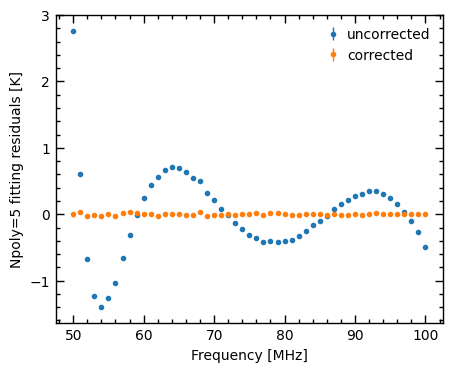

In [12]:
Npoly=5
p0 = [10, -2.5]
p0 += [0.01]*(Npoly-2)
priors = [[1, 25], [-3.5, -1.5]]
priors += [[-10, 10.1]]*(Npoly-2)
bounds = list(zip(*priors))
res = curve_fit_emcee(fg_polymod, nuarr, ts_fg_1, sigma_1, bounds=bounds, chain=True)

Npoly=5
p0 = [10, -2.5]
p0 += [0.01]*(Npoly-2)
priors = [[1, 25], [-3.5, -1.5]]
priors += [[-10, 10.1]]*(Npoly-2)
bounds = list(zip(*priors))
res_corr = curve_fit_emcee(fg_polymod, nuarr, ts_corr_fg_1, sigma_1, bounds=bounds, chain=True)

# Examine the residuals of both of these fits.
plt.errorbar(nuarr, ts_fg_1-fg_polymod(nuarr, *res[0]), sigma_1, fmt='.', label='uncorrected')
plt.errorbar(nuarr, ts_corr_fg_1-fg_polymod(nuarr, *res_corr[0]), sigma_1, fmt='.', label='corrected')
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Npoly=5 fitting residuals [K]")
plt.show()

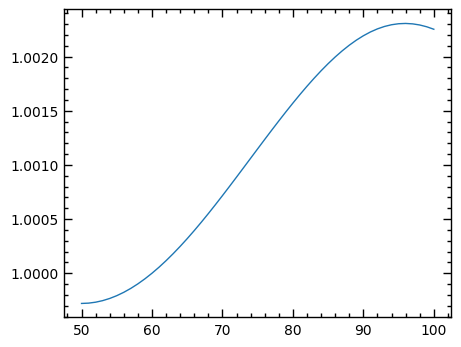

In [20]:
# Investigate whether binning the corrected timestream data will impact the foreground fitting.
binned_timestream = mat_G @ timestream
binned_timestream_corr = mat_G @ timestream_corr
binned_corr = mat_G @ corr

plt.plot(nuarr,binned_timestream/binned_timestream_corr)

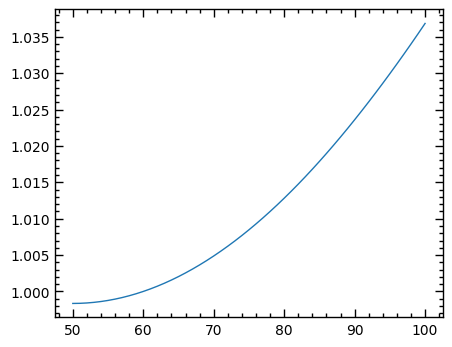

In [21]:
plt.plot(nuarr,binned_corr)

## What is the chrom corr actually doing? Let's see! (Frequency-flat foregrounds)
Visualise what the chromaticity correction is doing in our data. Observe (with 7 antennas) a fake foreground which has the spatial shape of the true foregrounds at 60 MHz, but also has the temperature of the foregrounds at 60 MHz for all frequencies. Plot this in data space (maybe both seperately AND binned into a single bin in one figure), then recover the alm and show that the monopole is super (hopefully) achromatic.
Acromagic.

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21


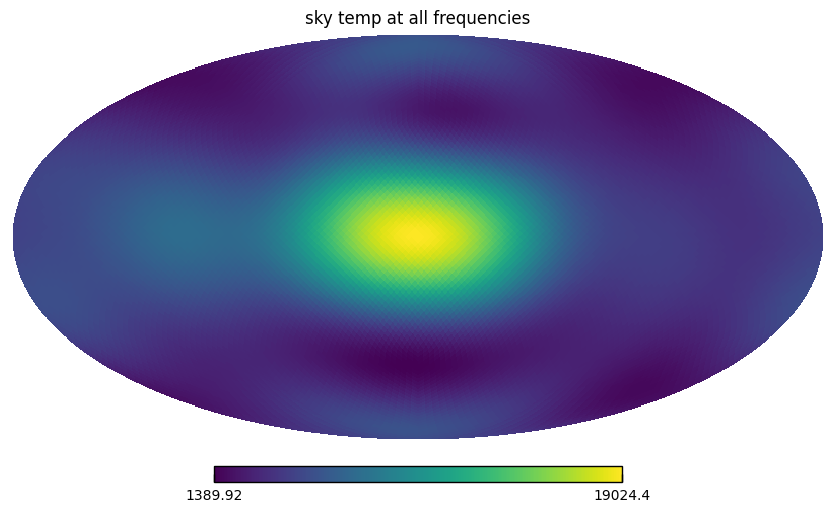

In [6]:
lmax=5
nside=32
Nlmax=RS.get_size(lmax)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=60, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=False)
mat_Y  = calc_spherical_harmonic_matrix(nside, lmax)
hp.mollview(mat_Y@fg_alm, title='sky temp at all frequencies')
mon_temp = fg_alm[0]*alm2temp

In [7]:
mat_Y_bl  = BlockMatrix(mat_Y, nblock=len(nuarr))
fg_alm_bl = BlockVector(fg_alm, nblock=len(nuarr), mode='block')


In [8]:
def gen_chrom_obs(chrom):
    lats      = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    times     = np.linspace(0, 24, 12, endpoint=False)
    chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    
    mat_A, (mat_G, mat_P, mat_Y_bl, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
        nuarr, nside, lmax, lats=lats, times=times, 
        return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
    )
    d = mat_P @ mat_Y_bl @ mat_B @ fg_alm_bl
    cov = np.diag([1.]*len(d.block[0]))
    cov_bl = BlockMatrix(cov, nblock=len(nuarr))
    return d, cov_bl, mat_P @ mat_Y_bl @ mat_B

chrom_list = [0, 1.6e-2, 3.4e-2, 4.5e-2]
ds = []
covs = []
obs_mats = []
for chrom in chrom_list:
    d, cov, mat_A = gen_chrom_obs(chrom)
    ds.append(d)
    covs.append(cov)
    obs_mats.append(mat_A)

'\nThis is the percentage difference between temperature space time-averaged multi-antenna observations \nof the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground\ntemperature with lmax=5.\n'

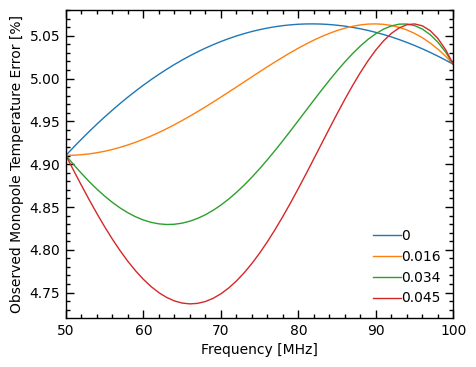

In [9]:
# Visualise the data.
for d, chrom in zip(ds, chrom_list):
    d_tot = np.zeros_like(d[0])
    for i in range(len(nuarr)):
        d_tot += d[i]
    plt.plot(nuarr, 100*(d_tot/len(nuarr)-mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Observed Monopole Temperature Error [%]")
"""
This is the percentage difference between temperature space time-averaged multi-antenna observations 
of the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground
temperature with lmax=5.
"""

In [10]:
# Estimate the alm from the data.
alm_ests = []
for d, cov_bl, mat_A in zip(ds, covs, obs_mats):
    mat_W   = MM.calc_ml_estimator_matrix(mat_A=mat_A, mat_N=cov_bl, cond=True)
    alm_est = mat_W @ d
    alm_ests.append(alm_est)

1/condition #: 3.2955051068391244e-09
1/condition #: 3.2955051068440233e-09
1/condition #: 4.454047939606732e-07
1/condition #: 6.773633118070418e-08


'\nThis is the percentage difference between the fiducial foreground monopole of the sky and the \nrecovered monopole from chromatic multi-antenna observations, assuming a spectrally constant \nforeground temperature with lmax=5.\n'

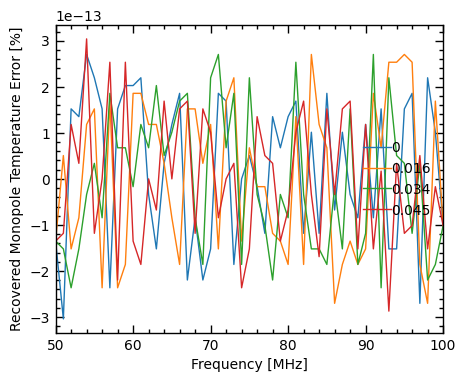

In [11]:
# Visualise the data.
for alm_est, chrom in zip(alm_ests, chrom_list):
    plt.plot(nuarr, 100*(alm_est[0]*alm2temp - mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.ticklabel_format(useOffset=False)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Recovered Monopole Temperature Error [%]")
"""
This is the percentage difference between the fiducial foreground monopole of the sky and the 
recovered monopole from chromatic multi-antenna observations, assuming a spectrally constant 
foreground temperature with lmax=5.
"""

## Do the same, but with the GSMA.

In [2]:
lmax=5
nside=32
Nlmax=RS.get_size(lmax)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=False)
fg_alm = BlockVector(fg_alm, nblock=len(nuarr))
mon_temp = fg_alm[0]*alm2temp

def gen_chrom_obs(chrom):
    lats      = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    times     = np.linspace(0, 24, 12, endpoint=False)
    chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    
    mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
        nuarr, nside, lmax, lats=lats, times=times, 
        return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
    )
    d = mat_P @ mat_Y @ mat_B @ fg_alm
    cov = np.diag([1.]*len(d.block[0]))
    cov_bl = BlockMatrix(cov, nblock=len(nuarr))
    return d, cov_bl, mat_P @ mat_Y @ mat_B

chrom_list = [0, 1.6e-2, 3.4e-2]
ds = []
covs = []
obs_mats = []
for chrom in chrom_list:
    d, cov, mat_A = gen_chrom_obs(chrom)
    ds.append(d)
    covs.append(cov)
    obs_mats.append(mat_A)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


'\nThis is the percentage difference between temperature space time-averaged multi-antenna observations \nof the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground\ntemperature with lmax=5.\n'

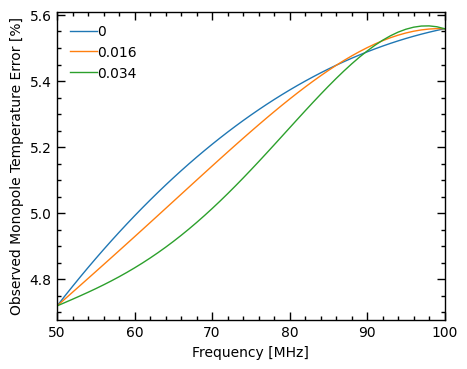

In [3]:
# Visualise the data.
for d, chrom in zip(ds, chrom_list):
    d_tot = np.zeros_like(d[0])
    for i in range(len(nuarr)):
        d_tot += d[i]
    plt.plot(nuarr, 100*(d_tot/len(nuarr)-mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Observed Monopole Temperature Error [%]")
"""
This is the percentage difference between temperature space time-averaged multi-antenna observations 
of the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground
temperature with lmax=5.
"""

In [4]:
# Estimate the alm from the data.
alm_ests = []
for d, cov_bl, mat_A in zip(ds, covs, obs_mats):
    mat_W   = MM.calc_ml_estimator_matrix(mat_A=mat_A, mat_N=cov_bl, cond=True)
    alm_est = mat_W @ d
    alm_ests.append(alm_est)

1/condition #: 3.2955051068391244e-09
1/condition #: 3.2955051068440233e-09
1/condition #: 4.454047939606732e-07


'\nThis is the percentage difference between the fiducial foreground monopole of the sky and the \nrecovered monopole from chromatic multi-antenna observations, assuming a spectrally constant \nforeground temperature with lmax=5.\n'

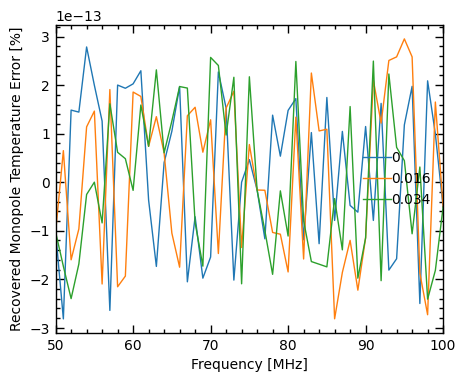

In [5]:
# Visualise the data.
for alm_est, chrom in zip(alm_ests, chrom_list):
    plt.plot(nuarr, 100*(alm_est[0]*alm2temp - mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.ticklabel_format(useOffset=False)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Recovered Monopole Temperature Error [%]")
"""
This is the percentage difference between the fiducial foreground monopole of the sky and the 
recovered monopole from chromatic multi-antenna observations, assuming a spectrally constant 
foreground temperature with lmax=5.
"""

## Do the same, but with the GSMA + 21-cm monopole

In [11]:
lmax=5
nside=32
Nlmax=RS.get_size(lmax)
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=False)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=OBS.cm21_params)
fid_alm  = BlockVector(fg_alm+cm21_alm, nblock=len(nuarr))
mon_temp = fid_alm[0]*alm2temp

def gen_chrom_obs(chrom):
    lats      = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    times     = np.linspace(0, 24, 12, endpoint=False)
    chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    
    mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
        nuarr, nside, lmax, lats=lats, times=times, 
        return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
    )
    d = mat_P @ mat_Y @ mat_B @ fid_alm
    cov = np.diag([1.]*len(d.block[0]))
    cov_bl = BlockMatrix(cov, nblock=len(nuarr))
    return d, cov_bl, mat_P @ mat_Y @ mat_B

chrom_list = [0, 1.6e-2, 3.4e-2]
ds = []
covs = []
obs_mats = []
for chrom in chrom_list:
    d, cov, mat_A = gen_chrom_obs(chrom)
    ds.append(d)
    covs.append(cov)
    obs_mats.append(mat_A)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


'\nThis is the percentage difference between temperature space time-averaged multi-antenna observations \nof the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground\ntemperature with lmax=5.\n'

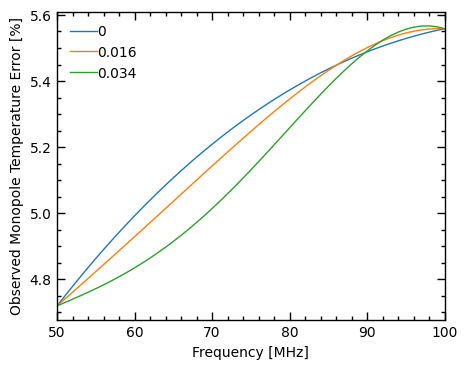

In [12]:
# Visualise the data.
for d, chrom in zip(ds, chrom_list):
    d_tot = np.zeros_like(d[0])
    for i in range(len(nuarr)):
        d_tot += d[i]
    plt.plot(nuarr, 100*(d_tot/len(nuarr)-mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Observed Monopole Temperature Error [%]")
"""
This is the percentage difference between temperature space time-averaged multi-antenna observations 
of the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground
temperature with lmax=5.
"""

In [13]:
# Estimate the alm from the data.
alm_ests = []
for d, cov_bl, mat_A in zip(ds, covs, obs_mats):
    mat_W   = MM.calc_ml_estimator_matrix(mat_A=mat_A, mat_N=cov_bl, cond=True)
    alm_est = mat_W @ d
    alm_ests.append(alm_est)

1/condition #: 3.2955051068391244e-09
1/condition #: 3.2955051068440233e-09
1/condition #: 4.454047939606732e-07


'\nThis is the percentage difference between the fiducial foreground monopole of the sky and the \nrecovered monopole from chromatic multi-antenna observations, assuming a spectrally constant \nforeground temperature with lmax=5.\n'

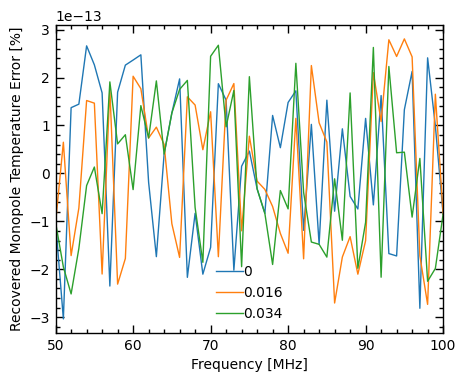

In [14]:
# Visualise the data.
for alm_est, chrom in zip(alm_ests, chrom_list):
    plt.plot(nuarr, 100*(alm_est[0]*alm2temp - mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.ticklabel_format(useOffset=False)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Recovered Monopole Temperature Error [%]")
"""
This is the percentage difference between the fiducial foreground monopole of the sky and the 
recovered monopole from chromatic multi-antenna observations, assuming a spectrally constant 
foreground temperature with lmax=5.
"""

## Section conclusion
Looks like we're getting absolutely perfect reconstruction in ALL cases. This can't be right - either there's a bug in the main code, or noise in the data ruins everything. Let's see with 5mK noise.

## 

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21


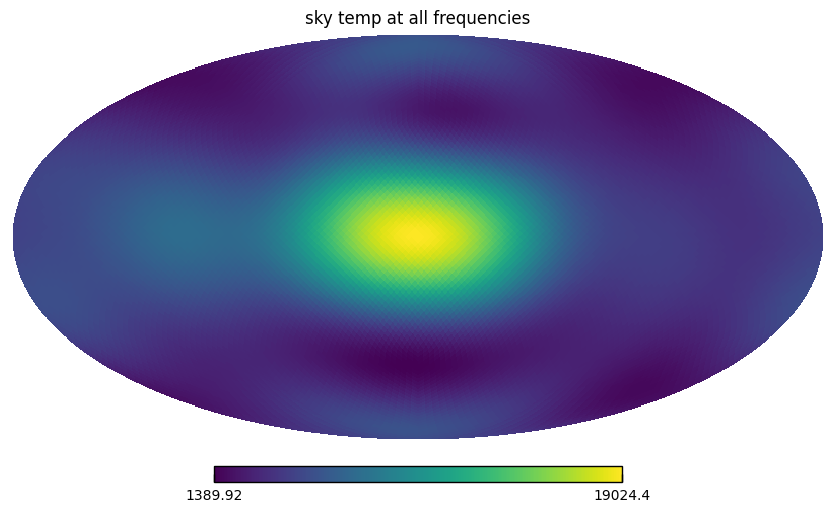

In [3]:
lmax=5
nside=32
Nlmax=RS.get_size(lmax)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=60, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=False)
mat_Y  = calc_spherical_harmonic_matrix(nside, lmax)
hp.mollview(mat_Y@fg_alm, title='sky temp at all frequencies')
mon_temp = fg_alm[0]*alm2temp

mat_Y_bl  = BlockMatrix(mat_Y, nblock=len(nuarr))
fg_alm_bl = BlockVector(fg_alm, nblock=len(nuarr), mode='block')


In [5]:
def gen_chrom_obs(chrom):
    lats      = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    times     = np.linspace(0, 24, 12, endpoint=False)
    chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    
    mat_A, (mat_G, mat_P, mat_Y_bl, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
        nuarr, nside, lmax, lats=lats, times=times, 
        return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
    )
    d = mat_P @ mat_Y_bl @ mat_B @ fg_alm_bl
    d, cov = SM.add_noise_uniform(d, 5e-3)
    return d, cov, mat_P @ mat_Y_bl @ mat_B

chrom_list = [0, 1.6e-2, 3.4e-2, 4.5e-2]
ds = []
covs = []
obs_mats = []
for chrom in chrom_list:
    d, cov, mat_A = gen_chrom_obs(chrom)
    ds.append(d)
    covs.append(cov)
    obs_mats.append(mat_A)

'\nThis is the percentage difference between temperature space time-averaged multi-antenna observations \nof the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground\ntemperature with lmax=5.\n'

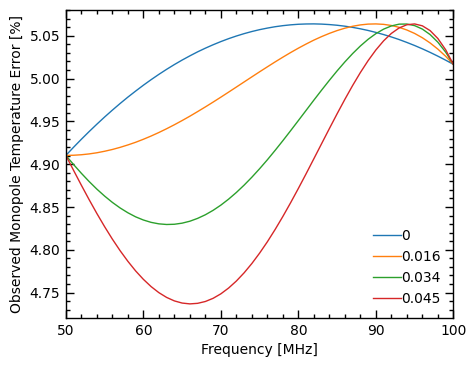

In [6]:
# Visualise the data.
for d, chrom in zip(ds, chrom_list):
    d_tot = np.zeros_like(d[0])
    for i in range(len(nuarr)):
        d_tot += d[i]
    plt.plot(nuarr, 100*(d_tot/len(nuarr)-mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Observed Monopole Temperature Error [%]")
"""
This is the percentage difference between temperature space time-averaged multi-antenna observations 
of the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground
temperature with lmax=5.
"""

In [7]:
# Estimate the alm from the data.
alm_ests = []
for d, cov_bl, mat_A in zip(ds, covs, obs_mats):
    mat_W   = MM.calc_ml_estimator_matrix(mat_A=mat_A, mat_N=cov_bl, cond=True)
    alm_est = mat_W @ d
    alm_ests.append(alm_est)

1/condition #: 3.2955051068391223e-09
1/condition #: 3.2955051068440225e-09
1/condition #: 4.454047939606732e-07
1/condition #: 6.773633118070416e-08


'\nThis is the percentage difference between the fiducial foreground monopole of the sky and the \nrecovered monopole from chromatic multi-antenna observations, assuming a spectrally constant \nforeground temperature with lmax=5.\n'

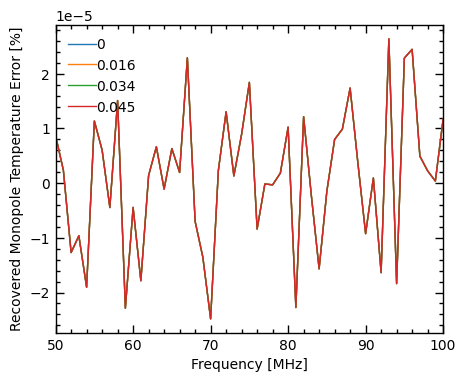

In [8]:
# Visualise the data.
for alm_est, chrom in zip(alm_ests, chrom_list):
    plt.plot(nuarr, 100*(alm_est[0]*alm2temp - mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.ticklabel_format(useOffset=False)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Recovered Monopole Temperature Error [%]")
"""
This is the percentage difference between the fiducial foreground monopole of the sky and the 
recovered monopole from chromatic multi-antenna observations, assuming a spectrally constant 
foreground temperature with lmax=5.
"""

## GSMA + 21-cm monopole + noise

In [6]:
lmax=5
nside=32
Nlmax=RS.get_size(lmax)
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=False)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=OBS.cm21_params)
fid_alm  = BlockVector(fg_alm+cm21_alm, nblock=len(nuarr))
mon_temp = fid_alm[0]*alm2temp

def gen_chrom_obs(chrom):
    lats      = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    times     = np.linspace(0, 24, 12, endpoint=False)
    chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    
    mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
        nuarr, nside, lmax, lats=lats, times=times, 
        return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
    )
    d = mat_P @ mat_Y @ mat_B @ fid_alm
    d, cov = SM.add_noise(d, dnu=1, Ntau=len(times), t_int=500, seed=123)
    return d, cov, mat_P @ mat_Y @ mat_B

chrom_list = [0, 1.6e-2, 3.4e-2]
ds = []
covs = []
obs_mats = []
for chrom in chrom_list:
    d, cov, mat_A = gen_chrom_obs(chrom)
    ds.append(d)
    covs.append(cov)
    obs_mats.append(mat_A)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21


'\nThis is the percentage difference between temperature space time-averaged multi-antenna observations \nof the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground\ntemperature with lmax=5.\n'

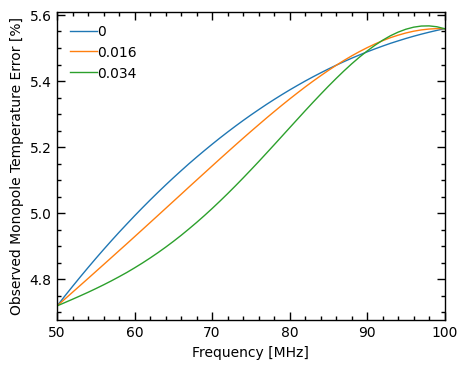

In [7]:
# Visualise the data.
for d, chrom in zip(ds, chrom_list):
    d_tot = np.zeros_like(d[0])
    for i in range(len(nuarr)):
        d_tot += d[i]
    plt.plot(nuarr, 100*(d_tot/len(nuarr)-mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Observed Monopole Temperature Error [%]")
"""
This is the percentage difference between temperature space time-averaged multi-antenna observations 
of the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground
temperature with lmax=5.
"""

In [8]:
# Estimate the alm from the data.
alm_ests = []
for d, cov_bl, mat_A in zip(ds, covs, obs_mats):
    mat_W   = MM.calc_ml_estimator_matrix(mat_A=mat_A, mat_N=cov_bl, cond=True)
    alm_est = mat_W @ d
    alm_ests.append(alm_est)

1/condition #: 9.530350675808675e-10
1/condition #: 1.584548741690459e-09
1/condition #: 2.8305704089490635e-07


'\nThis is the percentage difference between the fiducial foreground monopole of the sky and the \nrecovered monopole from chromatic multi-antenna observations, assuming a spectrally constant \nforeground temperature with lmax=5.\n'

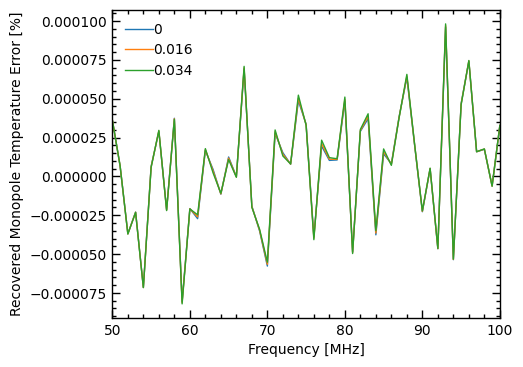

In [13]:
# Visualise the data.
for alm_est, chrom in zip(alm_ests, chrom_list):
    plt.plot(nuarr, 100*(alm_est[0]*alm2temp - mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.ticklabel_format(useOffset=False)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Recovered Monopole Temperature Error [%]")
"""
This is the percentage difference between the fiducial foreground monopole of the sky and the 
recovered monopole from chromatic multi-antenna observations, assuming a spectrally constant 
foreground temperature with lmax=5.
"""

Highly weird. I'd have thought that this error would have been bigger. This should correspond exactly to the percentage reconstruction error in all chromaticity cases for basemap error=0 in the main code. I'm even using exactly the same noise profile!

This percentage error, at approx 75 MHz, is corresponding to an error of about 10 mK
But in the main code, we're getting shaped residual error about a factor of 10 larger than that.

There are two factors there that are different to this implementation:
1. The mean-alm subtraction.
2. The addition of a missing-modes matrix to the data covariance matrix.

Investigate whether the addition of these factors mess with things here.

In [2]:
lmax  = 32
lmod  = 5
nside = 32
Nlmax = RS.get_size(lmax)
Nlmod = RS.get_size(lmod)
basemap_err = 0

fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=False, 
                                          delta=SM.basemap_err_to_delta(basemap_err))
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=OBS.cm21_params)
fid_alm  = BlockVector(fg_alm+cm21_alm, nblock=len(nuarr))
mon_temp = fid_alm[0]*alm2temp

alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, bmerr=basemap_err)

def gen_chrom_obs(chrom):
    lats      = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    times     = np.linspace(0, 24, 12, endpoint=False)
    chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    
    mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
        nuarr, nside, lmax, lats=lats, times=times, 
        return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
    )
    d = mat_P @ mat_Y @ mat_B @ fid_alm
    dnoisy, cov = SM.add_noise(d, dnu=1, Ntau=len(times), t_int=500, seed=123)

    mat_A_mod   = mat_A[:,:Nlmod]
    mat_A_unmod = mat_A[:,Nlmod:]
    
    data_corr  = mat_A_unmod @ alm_mean
    covar_corr = mat_A_unmod @ alm_cov @ mat_A_unmod.T

    d_corr = d - data_corr
    return d_corr, cov, mat_P @ mat_Y @ mat_B, covar_corr

chrom_list = [1.6e-2]
ds = []
covs = []
obs_mats = []
covar_corrs = []
for chrom in chrom_list:
    d, cov, mat_A, covar_corr, mat_A_mod = gen_chrom_obs(chrom)
    ds.append(d)
    covs.append(cov)
    obs_mats.append(mat_A)
    covar_corrs.append(covar_corr)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<0>


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
# Visualise the data.
for d, chrom in zip(ds, chrom_list):
    d_tot = np.zeros_like(d[0])
    for i in range(len(nuarr)):
        d_tot += d[i]
    plt.plot(nuarr, 100*(d_tot/len(nuarr)-mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Observed Monopole Temperature Error [%]")
"""
This is the percentage difference between temperature space time-averaged multi-antenna observations 
of the foreground sky and the fiducial foreground monopole, assuming a spectrally constant foreground
temperature with lmax=5.
"""

In [ ]:
# Estimate the alm from the data.
alm_ests = []
for d, cov_bl, mat_A, covar_corr, mat_A_mod in zip(ds, covs, obs_mats, covar_corrs, mat_A_mods):
    mat_W  ,_ = MM.calc_ml_estimator_matrix(mat_A=mat_A[:,:Nlmod], mat_N=cov_bl+covar_corr, cond=True, cov=True)
    alm_est = mat_W @ d
    alm_ests.append(alm_est)

In [ ]:
# Visualise the data.
for alm_est, chrom in zip(alm_ests, chrom_list):
    plt.plot(nuarr, 100*(alm_est[0]*alm2temp - mon_temp)/mon_temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.ticklabel_format(useOffset=False)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Recovered Monopole Temperature Error [%]")
"""
This is the percentage difference between the fiducial foreground monopole of the sky and the 
recovered monopole from chromatic multi-antenna observations, assuming a spectrally constant 
foreground temperature with lmax=5.
"""

In [ ]:
dnoisy=np.load('debug_dnoisy.npy')
data_corr=np.load('debug_data_corr.npy')
rec_alm = np.load('debug_rec_alm.npy')
db_mat_W = np.load('debug_mat_W.npy')

In [64]:
mat_W_res = mat_W - BlockMatrix(db_mat_W)

In [65]:
rec_alm

array([31404.20855862,  2608.5066092 ,   641.23371054, ...,
         286.74217723,   -59.5005356 ,   108.92114326])

In [66]:
mat_W_res.block

array([[[-3.54518763e-09, -4.17132633e-09, -5.28543045e-09, ...,
         -6.32731169e-09, -7.15584159e-09, -6.86241791e-09],
        [-8.52003263e-08, -8.97577817e-08, -1.37128983e-07, ...,
          2.87838038e-07,  3.46109188e-07,  3.31832911e-07],
        [-1.60515886e-07, -1.53137586e-07, -1.38436375e-07, ...,
          1.60258022e-07,  1.30107659e-07,  8.14558123e-08],
        ...,
        [ 8.91660573e-05,  1.16892727e-04,  9.40027014e-05, ...,
         -2.27938960e-05,  1.22745223e-05,  5.07402014e-05],
        [ 8.03993734e-05,  5.46685125e-05, -1.12054514e-05, ...,
          9.91995957e-05,  8.13437205e-05,  2.26187474e-05],
        [ 2.77071856e-05, -8.13791551e-06, -6.86491890e-05, ...,
          6.97243955e-05,  9.36483516e-05,  1.14877366e-04]],

       [[-3.35305165e-09, -3.94837824e-09, -5.01348543e-09, ...,
         -6.01026964e-09, -6.79892235e-09, -6.52024441e-09],
        [-8.48213772e-08, -8.92131373e-08, -1.36688934e-07, ...,
          2.88025304e-07,  3.46391011e

In [67]:
resids = ds[0]-BlockVector(dnoisy-data_corr, nblock=51)

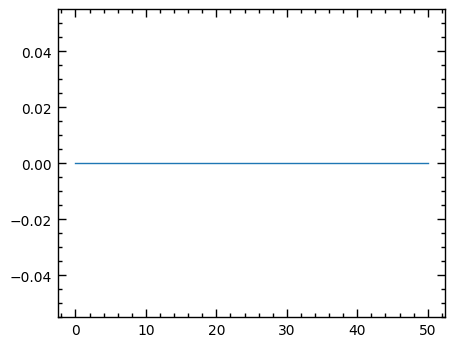

In [68]:
plt.plot(resids[0])

In [69]:
resid_alms = alm_ests[0]-BlockVector(rec_alm, nblock=51)


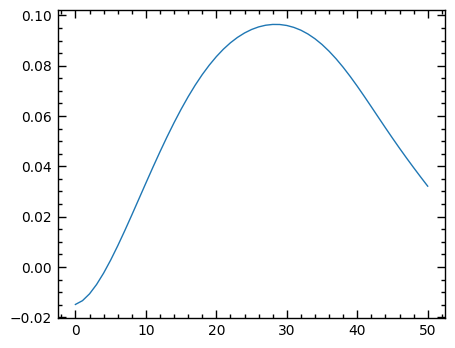

In [70]:
plt.plot(resid_alms[0])

I don't think it's the covariance correction, the data itself or the data correction, yet mat_W looks different here vs in the main code, and the monopole of the recovered alm looks different to the monopole of the recovered alm in the main code by a difference that looks like the weird alm residuals we're getting. 

Investigate the generation of mat_W.

In [ ]:
SH.

In [2]:
lmax  = 32
lmod  = 5
nside = 32
Nlmax = RS.get_size(lmax)
Nlmod = RS.get_size(lmod)
basemap_err = 0
chrom = 1.6e-2
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=False, 
                                          delta=SM.basemap_err_to_delta(basemap_err))
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=OBS.cm21_params)
fid_alm  = BlockVector(fg_alm+cm21_alm, nblock=len(nuarr))
mon_temp = fid_alm[0]*alm2temp

alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, bmerr=basemap_err)

lats      = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
times     = np.linspace(0, 24, 12, endpoint=False)
chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)

mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
    nuarr, nside, lmax, lats=lats, times=times, 
    return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
)
mat_A_mod1, (mat_G_mod1, mat_P_mod1, mat_Y_mod1, mat_B_mod1) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
    nuarr, nside, lmod, lats=lats, times=times, 
    return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<0>


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [30]:
mat_B

(1089, 1089) x 51 BlockMatrix

In [27]:
mat_A_res = mat_B[:Nlmod,:Nlmod] - mat_B_mod1

In [28]:
mat_A_res.block[3]

array([[ 2.60458119e-07,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.08126110e-05,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.08126110e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.51953584e-05,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -1.51953584e-05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.51953584e-05]])

In [6]:
mat_A_mod1

(84, 36) x 51 BlockMatrix

## Looks like the beam matrix is marginally different between the two cases. Looks like calling map2alm produces slightly different answers for different lmax values.

In [51]:
reload(BF)

<module 'src.beam_functions' from '/Users/yordani/Documents/boosted_compass/matrix-observer/src/beam_functions.py'>

In [62]:
blm_1 = BF.calc_blm(32, 32, lambda x: BF.beam_cos(x, 0.8))
blm_2 = BF.calc_blm(32, 5, lambda x: BF.beam_cos(x, 0.8))

In [63]:
blm_1[:36]-blm_2

array([-3.29404725e-06,  0.00000000e+00, -1.57146313e-06,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -6.55124351e-06,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.52742993e-06,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -8.02031916e-06,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.18273443e-06,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [68]:
blm_1[:36]

array([0.28214701, 0.        , 0.40650772, 0.        , 0.        ,
       0.        , 0.35577408, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.21966905, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08404571, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00281377, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

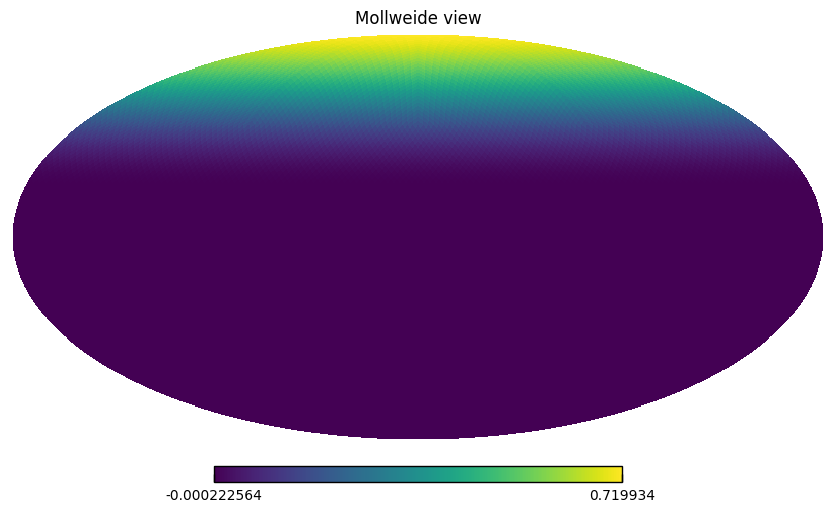

In [67]:
hp.mollview(mat_Y.block[0]@blm_1)

In [71]:
np.diag(mat_B.block[0])

array([ 1.00031504e+00,  8.80277410e-01,  8.80277410e-01, ...,
       -1.06148151e-04, -1.06148151e-04, -1.06148151e-04])

In [77]:
beamnc = lambda x: BF.beam_cos(x, 0.8)
nside = 32
npix = hp.nside2npix(nside)
bm   = np.zeros(npix)
for i in range(npix):
    theta, phi = hp.pixelfunc.pix2ang(nside, i)
    bm[i] = beamnc(theta)
blm = hp.sphtfunc.map2alm(bm, lmax=lmax, use_weights=False)

In [80]:
RS.complex2RealALM(blm)[:20]

array([ 1.86879014e-01,  1.73870306e-19,  2.69248856e-01,  1.19006014e-19,
       -6.23663931e-20,  2.96116392e-19,  2.35645622e-01,  2.05044208e-19,
       -1.16704500e-19, -6.09985235e-20, -1.64208034e-19,  3.12246779e-19,
        1.45496968e-01,  2.22911157e-19, -2.41200104e-19,  5.62883919e-20,
       -2.49556259e-20, -1.07319766e-19, -2.86264767e-19,  2.02701295e-19])

## Check that all of the above works in the achromatic case

In [81]:
lmax  = 32
lmod  = 5
nside = 32
Nlmax = RS.get_size(lmax)
Nlmod = RS.get_size(lmod)
basemap_err = 0

fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=False, 
                                          delta=SM.basemap_err_to_delta(basemap_err))
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=OBS.cm21_params)
fid_alm  = BlockVector(fg_alm+cm21_alm, nblock=len(nuarr))
mon_temp = fid_alm[0]*alm2temp

alm_mean, alm_cov = SM.gsma_corr(lmod, lmax, nside, nuarr, bmerr=basemap_err)

def gen_chrom_obs(chrom):
    lats      = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    times     = np.linspace(0, 24, 12, endpoint=False)
    chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    
    mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
        nuarr, nside, lmax, lats=lats, times=times, 
        return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
    )
    d = mat_P @ mat_Y @ mat_B @ fid_alm
    dnoisy, cov = SM.add_noise(d, dnu=1, Ntau=len(times), t_int=500, seed=123)

    mat_A_mod   = mat_A[:,:Nlmod]
    mat_A_unmod = mat_A[:,Nlmod:]
    
    data_corr  = mat_A_unmod @ alm_mean
    covar_corr = mat_A_unmod @ alm_cov @ mat_A_unmod.T

    d_corr = d - data_corr
    return d_corr, cov, mat_P @ mat_Y @ mat_B, covar_corr

chrom_list = [None]
ds = []
covs = []
obs_mats = []
covar_corrs = []
for chrom in chrom_list:
    d, cov, mat_A, covar_corr, mat_A_mod = gen_chrom_obs(chrom)
    ds.append(d)
    covs.append(cov)
    obs_mats.append(mat_A)
    covar_corrs.append(covar_corr)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<0>


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [12]:
mat_Y_pixlim = SH.calc_spherical_harmonic_matrix(nside=2, lmax=32)
mat_Y_llim = SH.calc_spherical_harmonic_matrix(nside=32, lmax=2)

calc_spherical_harmonic_matrix npix, nalm : 48 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 6


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


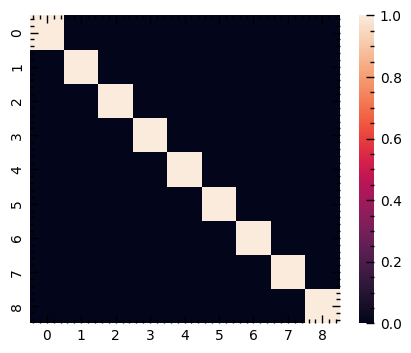

<Axes: >

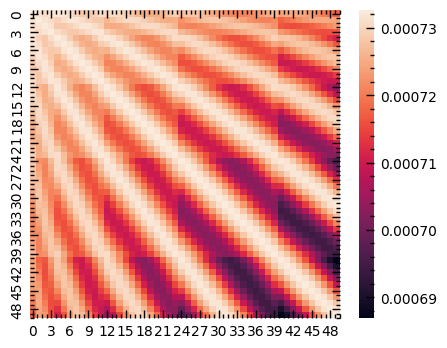

In [18]:
sns.heatmap(np.linalg.pinv(mat_Y_llim)@mat_Y_llim)  # Y^-1 Y
plt.show()
sns.heatmap((mat_Y_llim@np.linalg.pinv(mat_Y_llim))[:50,:50])  # Y Y^-1

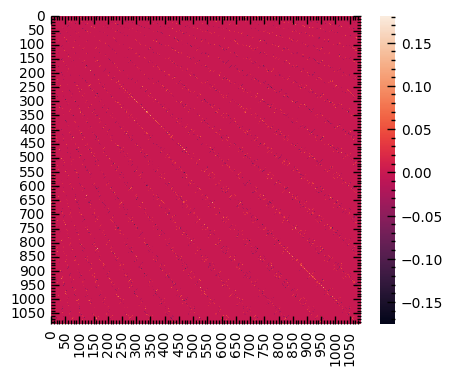

<Axes: >

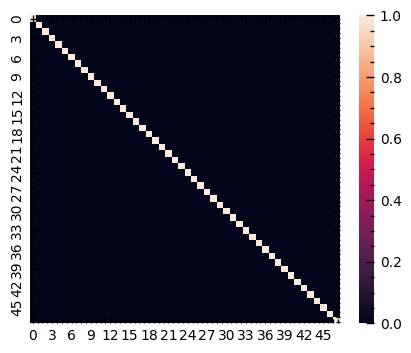

In [19]:
sns.heatmap(np.linalg.pinv(mat_Y_pixlim)@mat_Y_pixlim)  # Y^-1 Y
plt.show()
sns.heatmap((mat_Y_pixlim@np.linalg.pinv(mat_Y_pixlim))[:50,:50])  # Y Y^-1